# Spatial Transformer Networks

Jaderberg, Max, Karen Simonyan, and Andrew Zisserman. "Spatial transformer networks." Advances in Neural Information Processing Systems. 2015.

* 이미지가 distorted 되어 있는 경우, 이걸 먼저 transformation 해서 잘 align 해 주고 그 뒤에 classification 을 하겠다는 것.  
* CNN 이 생각보다 이러한 distortion 에 invariant 하지 않다는 단점을 해결하고자 함.
* Main reference:
    * https://kevinzakka.github.io/2017/01/10/stn-part1/
    * https://github.com/kevinzakka/spatial_transformer_network

## Affine transform on Numpy

* 이 논문에서 가장 이해하기 까다로운 부분이 이 affine transform 이었다. (물론 내 얘기...)
* 따라서 이 부분을 위 레퍼런스에 나온것처럼 먼저 넘파이로 구현해보자.

An image processing affine transformation usually follows the **3-step pipeline** below:

* First, we create a sampling grid composed of (x,y) coordinates. For example, given a 400x400 grayscale image, we create a meshgrid of same dimension, that is, evenly spaced x∈[0,W] and y∈[0,H].
* We then apply the transformation matrix to the sampling grid generated in the step above.
* Finally, we sample the resulting grid from the original image using the desired interpolation technique.

As you can see, this is different than directly applying a transform to the original image.

In [104]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [119]:
cat1 = Image.open("images/cat1.jpg")
cat2 = Image.open("images/cat2.jpg")

In [120]:
cat1.size, cat2.size

((400, 400), (400, 400))

In [121]:
cat1.format, cat2.format

('JPEG', 'JPEG')

In [122]:
np_cat1 = np.asarray(cat1)
np_cat2 = np.asarray(cat2)

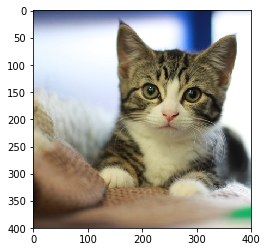

In [124]:
plt.imshow(np_cat1);

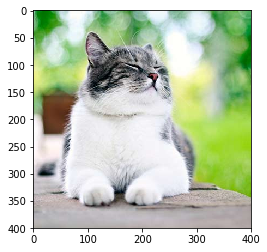

In [125]:
plt.imshow(np_cat2);

In [129]:
np_cat1.shape, np_cat2.shape

((400, 400, 3), (400, 400, 3))

In [139]:
# stack 은 이와 같이 이어붙이는게 아니라 말 그대로 쌓아준다.
# concat 은 이어붙인다.
np_cat = np.stack([np_cat1, np_cat2], axis=0)
np_cat.shape

(2, 400, 400, 3)

In [146]:
batch_size, H, W, C = np_cat.shape

### Affine transform matrix

In [141]:
# affine transform matrix
M = np.array([[1., 0., 0.], [0., 1., 0.]]) # identity function

In [144]:
# 이렇게 하면 이 아이덴티티 매트릭스가 batch_size 만큼 뻥튀기됨.
# 신기한데?
M = np.resize(M, (batch_size, 2, 3))

In [145]:
M

array([[[ 1.,  0.,  0.],
        [ 0.,  1.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  1.,  0.]]])

In [395]:
def affine_transform_matrix(M, batch_size):
    return np.resize(M, (batch_size, 2, 3))

### Step 1: sampling grid

In [160]:
# create normalized 2D grid
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
# 이 메쉬그리드가 좀 헷갈렸음. 
# x 를 y 축으로 stacking 하고 y 를 x 축으로 stacking 하는거임.
# 그래서 x_t == y_t.T 가 성립!
# 얘로 뭘 할수 있냐면, 우리가 애초에 만들고자 했었던 sampling grid 를 만들 수 있음.
# 즉, meshgrid[y,x] = (y,x) 가 성립함!
x_t, y_t = np.meshgrid(x, y)

In [161]:
x.shape, y.shape, x_t.shape, y_t.shape

((400,), (400,), (400, 400), (400, 400))

In [177]:
# 이제 이걸 논문에 나온것처럼 (xt, yt, 1) 형태로 재구성해주자
ones = np.ones(x_t.size)
sampling_grid = np.stack([x_t.flatten(), y_t.flatten(), ones], axis=0) # same as vstack

In [178]:
sampling_grid.shape

(3, 160000)

In [179]:
# 이제 하나의 sampling grid 를 만들었는데, 사실 이건 batch_size 만큼 필요함
sampling_grid = np.resize(sampling_grid, (batch_size, 3, H*W)) # H*W = x_t.size
sampling_grid.shape

(2, 3, 160000)

In [392]:
def make_sampling_grid(H, W):
    # create normalized 2D grid
    x = np.linspace(-1, 1, W)
    y = np.linspace(-1, 1, H)
    x_t, y_t = np.meshgrid(x, y)
    
    # 이제 이걸 논문에 나온것처럼 (xt, yt, 1) 형태로 재구성해주자
    ones = np.ones(x_t.size)
    sampling_grid = np.stack([x_t.flatten(), y_t.flatten(), ones], axis=0) # same as vstack
    
    # 이제 하나의 sampling grid 를 만들었는데, 사실 이건 batch_size 만큼 필요함
    sampling_grid = np.resize(sampling_grid, (batch_size, 3, H*W)) # H*W = x_t.size
    
    return sampling_grid

### Step 2: affine_transform_matrix * sampling_grid

In [181]:
# transform the sampling grid
# 이렇게하면 된다는게 좀 신기...
new_grids = np.matmul(M, sampling_grid)
# [N, 2, 3] * [N, 3, HW] = [N, 2, HW]

# reshape to (N, H, W, 2)
new_grids = np.reshape(new_grids, [batch_size, 2, H, W])
new_grids = np.moveaxis(new_grids, 1, -1) # axis=1 을 마지막으로 보냄 => [N, H, W, 2]
new_grids.shape

(2, 400, 400, 2)

In [393]:
def affine_transform(M, sampling_grid, H, W):
    new_grids = np.matmul(M, sampling_grid)
    # [N, 2, 3] * [N, 3, HW] = [N, 2, HW]
    
    # reshape to (N, H, W, 2)
    new_grids = np.reshape(new_grids, [batch_size, 2, H, W])
    new_grids = np.moveaxis(new_grids, 1, -1) # axis=1 을 마지막으로 보냄 => [N, H, W, 2]

    return new_grids

### Step 3: bilinear sampler

* 사실 이게 좀 복잡함
* bilinear interpolation 과정이 좀 복잡하기 때문

In [190]:
# 일단 x, y 를 분리해서 scaling 을 하자
x_s = new_grids[:, :, :, 0]
y_s = new_grids[:, :, :, 1]

# rescaling [-1, 1] => [0, W/H]
x = ((x_s + 1.) / 2.) * W
y = ((y_s + 1.) / 2.) * H

In [194]:
# interpolation 할 4개의 점을 잡아준다. 
# 이 각 좌표들은 소스에 대한 좌표임
x0 = np.floor(x).astype(np.int32)
x1 = x0 + 1
y0 = np.floor(y).astype(np.int32)
y1 = y0 + 1

In [195]:
# [0, W-1], [0, H-1] 범위 안에 들어오도록 클리핑을 해준다.
x0 = np.clip(x0, 0, W-1)
x1 = np.clip(x1, 0, W-1)
y0 = np.clip(y0, 0, H-1)
y1 = np.clip(y1, 0, H-1)

In [352]:
# 35 ms
# 이제 각 x,y 들은 소스 이미지의 어느 좌표에서 픽셀값을 가져와야 하는지 정보를 갖고 있다.
# 예를 들면, target[i, j] = source[y[i, j], x[i, j]] 가 되겠지.
# 이거를 2중 for loop 를 돌려도 되지만, numpy 로 간단히 할 수 있다.
Ia = np_cat[np.arange(batch_size)[:, None, None], y0, x0]
Ib = np_cat[np.arange(batch_size)[:, None, None], y1, x0]
Ic = np_cat[np.arange(batch_size)[:, None, None], y0, x1]
Id = np_cat[np.arange(batch_size)[:, None, None], y1, x1]

In [394]:
def bilinear_sampling(sources, new_grids, H, W):
    # 일단 x, y 를 분리해서 scaling 을 하자
    x_s = new_grids[:, :, :, 0]
    y_s = new_grids[:, :, :, 1]

    # rescaling [-1, 1] => [0, W/H]
    x = ((x_s + 1.) / 2.) * W
    y = ((y_s + 1.) / 2.) * H
    
    # interpolation 할 4개의 점을 잡아준다. 
    # 이 각 좌표들은 소스에 대한 좌표임
    x0 = np.floor(x).astype(np.int32)
    x1 = x0 + 1
    y0 = np.floor(y).astype(np.int32)
    y1 = y0 + 1
    
    # [0, W-1], [0, H-1] 범위 안에 들어오도록 클리핑을 해준다.
    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)
    
    # pixel value
    Ia = sources[np.arange(batch_size)[:, None, None], y0, x0]
    Ib = sources[np.arange(batch_size)[:, None, None], y1, x0]
    Ic = sources[np.arange(batch_size)[:, None, None], y0, x1]
    Id = sources[np.arange(batch_size)[:, None, None], y1, x1]

    # interpolation weights coef
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)
    
    wa = np.expand_dims(wa, axis=3)
    wb = np.expand_dims(wb, axis=3)
    wc = np.expand_dims(wc, axis=3)
    wd = np.expand_dims(wd, axis=3)
    
    out = wa*Ia + wb*Ib + wc*Ic + wd*Id
    out = out.astype(np.uint8)
    
    return out

#### Understanding numpy

In [271]:
Fa = np.zeros_like(np_cat)
Fb = np.zeros_like(np_cat)
Fc = np.zeros_like(np_cat)
Fd = np.zeros_like(np_cat)

In [279]:
# %%timeit # 1.14s
# for loop 로도 구현해보자.
for k in range(batch_size):
    for i in range(H):
        for j in range(W):
            # Fa[k, i, j] = np_cat[k, y0[k, i, j], x0[k, i, j]]
            # Fa[k, i, j, :] = np_cat[k, y0[k, i, j], x0[k, i, j], :]
            # : 안쓰는게 훨 빠르다 (1.44s => 1.14s)
            Fa[k, i, j] = np_cat[k, y0[k, i, j], x0[k, i, j]]
            Fb[k, i, j] = np_cat[k, y1[k, i, j], x0[k, i, j]]
            Fc[k, i, j] = np_cat[k, y0[k, i, j], x1[k, i, j]]
            Fd[k, i, j] = np_cat[k, y1[k, i, j], x1[k, i, j]]
            
(Fa == Ia).all(), (Fb == Ib).all(), (Fc == Ic).all(), (Fd == Id).all()

1 loop, best of 3: 1.14 s per loop


In [317]:
tmp = np.arange(9).reshape(3,3)
tmp

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [318]:
tmp[:, [0, 1, 2]] = 1
tmp

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [319]:
tmp[np.arange(3), [0, 1, 2]] = 4
tmp

array([[4, 1, 1],
       [1, 4, 1],
       [1, 1, 4]])

In [325]:
# %%timeit # 2.8 s => 더 느려졌는데...?
# idx 밖으로 빼니까 2.37 s => 그래도 느리네
# 이번엔 위 루프에서 k 를 없애보자.
'''
np_cat[:, 5, 5], np_cat[np.arange(batch_size), 5, 5] 를 해 보면 둘다 (2,3) 짜리 매트릭스가 나온다. 
np_cat 이 (2, 400, 400, 3) 이니까, 각 데이터 포인트의 (5, 5) 좌표의 RGB 가 나오는것이다. 직관적으로 이해가 된다.

1. np_cat[:, y0[:, i, j], x0[:, i, j]]
2. np_cat[np.arange(batch_size), y0[:, i, j], x0[:, i, j]]

문제는 이 두개의 차인데... 말로 설명하자니 괜히 더 어려워지는것 같다. 위 예제를 참고하자. 
암튼 이 경우에는 1번과 2번의 기능이 달라진다는 것은 알아두자.
'''
idx = np.arange(batch_size)
for i in range(H):
    for j in range(W):
        # 차이를 살짝 알 것 같다!
        Fa[:, i, j] = np_cat[idx, y0[:, i, j], x0[:, i, j]]
        Fb[:, i, j] = np_cat[idx, y1[:, i, j], x0[:, i, j]]
        Fc[:, i, j] = np_cat[idx, y0[:, i, j], x1[:, i, j]]
        Fd[:, i, j] = np_cat[idx, y1[:, i, j], x1[:, i, j]]
            
(Fa == Ia).all(), (Fb == Ib).all(), (Fc == Ic).all(), (Fd == Id).all()

(True, True, True, True)

In [343]:
# 그럼 이제 i, j 도 줄일 수 있다.
# 이게 구체적으로 어떻게 되는진 나도 잘 모르겠음.
# 제일 앞에 idx 의 shape 이 (2,1,1) 이니까... 
# (2,1,1) 에 대해서 loop 를 돈다고 생각하면 되려나?
# 위에서는 (2) 니까, 뭐 그렇게 이해하면 될것도 같음. 대충...
idx = np.arange(batch_size)[:, None, None]
print idx
print idx.shape

Fa = np_cat[idx, y0, x0]
Fb = np_cat[idx, y1, x0]
Fc = np_cat[idx, y0, x1]
Fd = np_cat[idx, y1, x1]

(Fa == Ia).all(), (Fb == Ib).all(), (Fc == Ic).all(), (Fd == Id).all()

[[[0]]

 [[1]]]
(2, 1, 1)


(True, True, True, True)

#### get back to the bilinear sampling

In [344]:
# calculate deltas
# bilinear interpolation weight coefficients
# 아까 잡은 4개의 점과, 실제 (x,y) 와의 delta 를 구함 - 각각 x, y를 빼주고 곱해서 계산
# 이 각각의 값들은 interpolation weight 이므로, 각각 그 가중치에 맞도록 계산을 해준 것.
wa = (x1-x) * (y1-y)
wb = (x1-x) * (y-y0)
wc = (x-x0) * (y1-y)
wd = (x-x0) * (y-y0)

In [347]:
wa = np.expand_dims(wa, axis=3)
wb = np.expand_dims(wb, axis=3)
wc = np.expand_dims(wc, axis=3)
wd = np.expand_dims(wd, axis=3)

In [358]:
wa.shape, Ia.shape # => broadcasting in axis=3

((2, 400, 400, 1), (2, 400, 400, 3))

In [389]:
out = wa*Ia + wb*Ib + wc*Ic + wd*Id
out = out.astype(np.uint8)

## Experiments

In [400]:
M = np.array([[0.707, -0.707, 0.], [0.707, 0.707, 0.]])
M = affine_transform_matrix(M, batch_size)
sampling_grid = make_sampling_grid(H, W)
new_grids = affine_transform(M, sampling_grid)
out = bilinear_sampling(np_cat, new_grids, H, W)

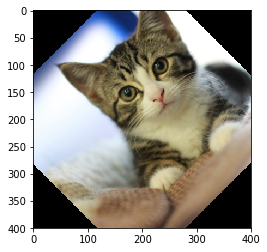

In [401]:
plt.imshow(out[0].astype(np.uint8))
plt.show()

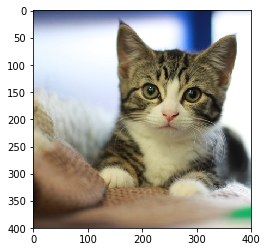

In [399]:
plt.imshow(np_cat1)